In [1]:
from PIL import Image, ImageCms
import math
import numpy as np

In [2]:
srgb_profile = ImageCms.createProfile("sRGB")
lab_profile  = ImageCms.createProfile("LAB")
rgb2lab_transform = ImageCms.buildTransform(srgb_profile, lab_profile, "RGB", "LAB")
lab2rgb_transform = ImageCms.buildTransform(lab_profile, srgb_profile, "LAB", "RGB")

In [3]:
# General functions
def openImg(filename):
    im = Image.open(filename)
    print(im.format, im.size, im.mode)
    return im

def rgb2lab(image):
    if image.mode == "RGBA" or image.mode == "RGB":
        return ImageCms.applyTransform(image, rgb2lab_transform)
    else:
        raise Exception('Image is not RGB/RGBA')

def lab2rgb(image):
    if image.mode == "LAB":
        return ImageCms.applyTransform(image, lab2rgb_transform)
    else:
        raise Exception('Image is not LAB')
        
def getLabDistance(L1, a1, b1, L2, a2, b2):
    L = L1-L2
    a = a1-a2
    b = b1-b2
    return math.sqrt((L*L)+(a*a)+(b*b))

PNG (300, 300) RGBA


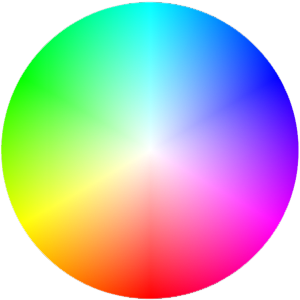

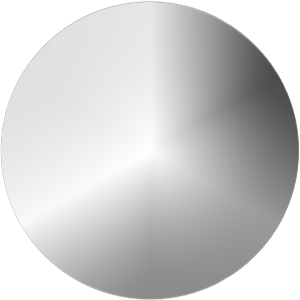

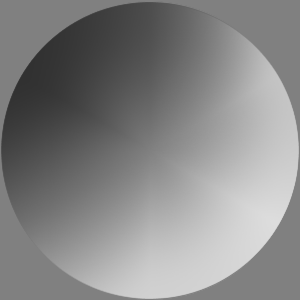

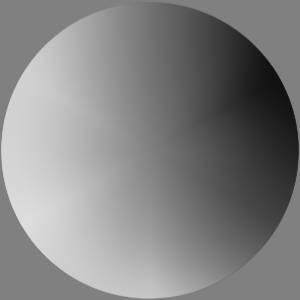

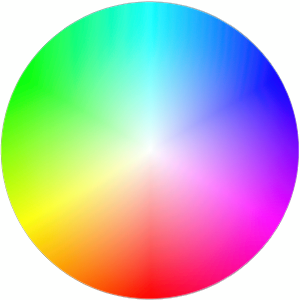

In [4]:
im = openImg('sample_colorwheel.png')
im_lab = rgb2lab(im)
im_rgb = lab2rgb(im_lab)
L, a, b = im_lab.split()
display(im, L, a, b, im_rgb)

In [48]:
# Color Palette Selection
def binRGB(image):
    binR = np.zeros((16,4))
    binG = np.zeros((16,4))
    binB = np.zeros((16,4))
    for c in range(im.size[0]):
        for r in range(im.size[1]):
            rgb = image.getpixel((r,c))
            rgb = np.array([rgb[0], rgb[1], rgb[2], 1])
            Rindex = rgb[0]//16
            Gindex = rgb[1]//16
            Bindex = rgb[2]//16
            binR[Rindex] += rgb
            binG[Gindex] += rgb
            binB[Bindex] += rgb
    return binR, binG, binB
    
binR, binG, binB = binRGB(im)
print(binR)

[[2.2008000e+04 5.1598300e+05 5.0044900e+05 2.6440000e+03]
 [6.8813000e+04 5.5890900e+05 5.5903000e+05 2.9290000e+03]
 [1.1425700e+05 5.5641900e+05 5.5035900e+05 2.8960000e+03]
 [1.6450900e+05 5.6895800e+05 5.6669700e+05 2.9660000e+03]
 [2.0926700e+05 5.6363900e+05 5.5827500e+05 2.9230000e+03]
 [2.5385300e+05 5.5317700e+05 5.5470500e+05 2.9030000e+03]
 [3.0689100e+05 5.6941000e+05 5.6561600e+05 2.9680000e+03]
 [3.5074400e+05 5.5982200e+05 5.6118900e+05 2.9360000e+03]
 [3.9635000e+05 5.6093000e+05 5.5688500e+05 2.9250000e+03]
 [4.3913000e+05 5.5497600e+05 5.5115100e+05 2.9000000e+03]
 [4.9731000e+05 5.6682100e+05 5.6843100e+05 2.9710000e+03]
 [5.4866900e+05 5.7152400e+05 5.6817600e+05 2.9900000e+03]
 [6.2346900e+05 5.9695700e+05 5.9298700e+05 3.1250000e+03]
 [6.6331700e+05 5.9004600e+05 5.8927300e+05 3.0800000e+03]
 [7.3360200e+05 6.1276600e+05 6.0937400e+05 3.1700000e+03]
 [1.1624009e+07 8.5338930e+06 8.5073520e+06 4.5674000e+04]]
